In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])/1e4).astype('int')
Ni[1] = (np.sum(Ni0[4:8])/1e4).astype('int')
Ni[2] = (np.sum(Ni0[8:12])/1e4).astype('int')
Ni[3] = (np.sum(Ni0[12:16])/1e4).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )

In [4]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.7, 0.6, 0.5

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [6]:
beta  = 0.00454      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*100
Is_0[1] += 100 #make one group different 
Ia_0 = np.ones((M))*20
# Ia_0[1] += 20
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=80;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)
np.save('cal_lat_SIR_traj.npy', data['X'])

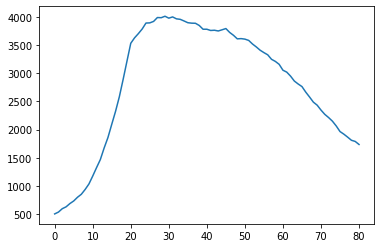

In [7]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

### Compare the deterministic trajectory and the stochastic one before intervention

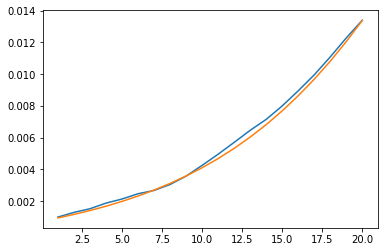

In [8]:
Tf_initial = 20 # truncate to only getting the first few datapoints 
Nf_initial = Tf_initial+1

x = np.load('cal_lat_SIR_traj.npy')
x = (x/N)[:Nf_initial]
steps = 101 # number internal integration steps taken

fltr=np.repeat(np.array([False, False, True]), M)
obs=x[:, fltr] 

contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
xm,full_cov = estimator.obtain_full_mean_cov(x[0], Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(1, Tf_initial, Nf_initial-1)
plt.plot(t, x[1:,2*M])
plt.plot(t, xm[:,2*M])
plt.show()

In [9]:
# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x[0], obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-659.9351633652395
0.4987318515777588


In [10]:
# take a guess 
beta_g = 0.005
gIa_g = 0.15
gIs_g = 0.15
alpha_g = 0.25
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])



eps = 1e-3 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.25
alpha_bounds = (0.1, 0.4)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.005
beta_bounds = (1e-3, 0.01)

gIa_g = 0.12
gIa_bounds = (0.1, 0.2)

gIs_g = 0.14
gIs_bounds = (0.13, 0.15) 

fsa_g = 0.8

Is0_g = Is_0/N 
bounds_for_Is = [(1/N, 1200/N)]*M 
bounds_for_Is[1] = (180/N, 220/N)

Ia0_g = (Ia_0)/N
bounds_for_Ia = [(1/N, 1000/N)]*M
print(Ia0_g, bounds_for_Ia)

S0_g = S_0/N
bounds_for_S = [(fi[i]-400/N, fi[i]-bounds_for_Is[i][0]/N) for i in range(M)]


# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
sigma = .001*np.ones(guess.shape)
print([bounds[i,0]<guess[i]<bounds[i,1] for i in range(len(guess))])
params = estimator.latent_inference(guess,sigma, obs, fltr, Tf_initial, Nf_initial, contactMatrix,
                                    bounds, beta_rescale=1, verbose=True, niter=2, ftol=ftol, eps=eps,
                                   global_max_iter=15)
# the L-BFGS-B method prints to the terminal rather than here 

[0.00014778 0.00014778 0.00014778 0.00014778] [(7.389180761528969e-06, 0.00738918076152897), (7.389180761528969e-06, 0.00738918076152897), (7.389180761528969e-06, 0.00738918076152897), (7.389180761528969e-06, 0.00738918076152897)]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 16 (seed=494541, Fri May  1 12:01:21 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -7.473798568962123e+02 1.0e+00 9.21e-01  3e-04  3e-04 0:08.4
    2     32 -7.530259130586445e+02 1.1e+00 9.17e-01  3e-04  3e-04 0:15.9
    3     48 -7.545973565445134e+02 1.2e+00 9.04e-01  3e-04  3e-04 0:22.9
    4     64 -7.539462156937094e+02 1.3e+00 8.90e-01  3e-04  3e-04 0:29.7
    5     80 -7.543444223804753e+02 1.3e+00 8.20e-01  3e-04  3e-04 0:36.6
    6     96 -7.545263869143000e+02 1.3e+00 7.67e-01  2e-04  3e-04 0:43.7
    7    112 -7.547837877915508e

In [11]:
# save the parameters 
np.save('SIR_cal_lat_param.npy', params)

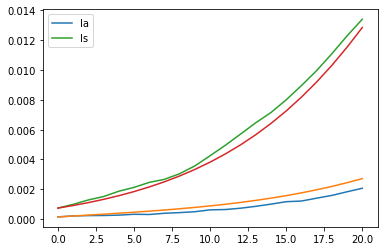

In [12]:
# check the predictions 
params = np.load('SIR_cal_lat_param.npy')
x = np.load('cal_lat_SIR_traj.npy')/N
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
estimator.set_params(parameters)
x0 = params[len(parameters)-1:]
det_model = pyross.deterministic.SIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x_det = estimator.integrate(x0, 0, Tf_initial, Nf_initial, det_model, contactMatrix)
plt.plot(x[:Nf_initial,1*M+1], label='Ia')
plt.plot(x_det[:, 1*M+1])
plt.plot(x[:Nf_initial,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

In [13]:
aW_g = 0.6 
aW_bounds = [0.2, 0.8]
aS_g = 0.6
aS_bounds = [0.2, 0.8]
aO_g = 0.6
aO_bounds = [0.2, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = np.load('cal_lat_SIR_traj.npy')/N
x = x[Nf_initial:]
obs = x[:, fltr]
Nf_control = x.shape[0] 
Tf_control = Nf_control-1 

det_model = pyross.deterministic.SIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x0 = estimator.integrate(params[-3*M:], 0, Tf_initial, 2, det_model, contactMatrix)[-1]
x0 = np.array(x0)
times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
parameters = estimator.make_params_dict(params)
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_control, Nf_control, contactMatrix)
print(logp) 

-1804.2090634322553


In [ ]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
control_params = estimator.latent_infer_control(guess,.1*np.ones(guess.shape), x0, obs, fltr, Tf_control, Nf_control, generator, bounds,
                                  niter=2, eps=eps, verbose=True, global_max_iter=15)
end_time = time.time()
print(control_params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=462606, Fri May  1 12:08:45 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.795392937264768e+03 1.0e+00 1.09e+00  6e-02  9e-02 0:25.8
    2     32 -1.812899382541421e+03 1.8e+00 1.23e+00  8e-02  9e-02 0:51.2
    3     48 -1.820068035845389e+03 2.0e+00 1.51e+00  9e-02  1e-01 1:15.9
    4     64 -1.816114870994217e+03 1.9e+00 1.57e+00  9e-02  1e-01 1:40.4
    5     80 -1.819010914198610e+03 2.2e+00 1.61e+00  8e-02  1e-01 2:05.5
    6     96 -1.820683413243682e+03 2.0e+00 1.25e+00  5e-02  8e-02 2:30.6
    7    112 -1.819737224361263e+03 2.7e+00 1.05e+00  4e-02  6e-02 2:54.5
    8    128 -1.820547966525437e+03 3.4e+00 8.72e-01  3e-02  5e-02 3:16.9
    9    144 -1.820378259998566e+03 3.7e+00 6.57e-01  2e-02  3e-02 3:39.8
   10    160 -1.820666515637570e+03 4.3e+00 5.59e-01  2e-02  3e-02 4:02.2
   11    176 -1.820766664403147e+03 4.7e+00 4.82e-01  1e-02  2e-0

In [ ]:
times = [20]
interventions = [[1.0,1.0,1.0],      # before first time
                 control_params,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x0 = params[len(parameters)-1:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('cal_lat_SIR_traj.npy')/N
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()